In [1]:
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (24, 10)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 18

In [2]:
with open("analysis/society-deadlock.pickle", "rb") as f:
    data = pickle.load(f)

In [3]:
THRESHOLDS = [
    0.99,
    0.98,
    0.97,
    0.96,
    0.95,
    0.94,
    0.93,
    0.92,
    0.91,
    0.9,
    0.875,
    0.85,
    0.825,
    0.8,
    0.7,
    0.6,
    0.5,
    0.4,
    0.3,
    0.2,
    0.1,
]

In [4]:
rows = []

with ProcessPoolExecutor(max_workers=6) as pool:
    futures = {
        pool.submit(get_graphs_at_thresholds, weights, THRESHOLDS): (population, lb)
        for (population, lb, t), weights_collection in data["train_weights"].items()
        for weights in weights_collection
    }

    for future in tqdm(as_completed(futures), total=len(futures)):
        population, lb = futures[future]
        Gs, edge_counts, clustering_coefficients = future.result()

        for threshold, edge_count, clustering_coefficient in zip(
            THRESHOLDS, edge_counts, clustering_coefficients
        ):
            rows.append([population, lb, threshold, edge_count, clustering_coefficient])

df = pd.DataFrame(
    rows,
    columns=[
        "population",
        "lookback",
        "threshold",
        "edge_count",
        "clustering_coefficient",
    ],
)

df

  0%|          | 0/300 [00:00<?, ?it/s]

,population,lookback,threshold,edge_count,clustering_coefficient
0,16,3,0.99,0,NaN
1,16,3,0.98,0,NaN
2,16,3,0.97,0,NaN
3,16,3,0.96,0,NaN
4,16,3,0.95,0,NaN
...,...,...,...,...,...
6295,256,2,0.50,25037,0.865654
6296,256,2,0.40,29273,0.927992
6297,256,2,0.30,31126,0.964263
6298,256,2,0.20,31779,0.977488


In [5]:
df.to_csv("analysis/deadlock_clustering_data.csv")

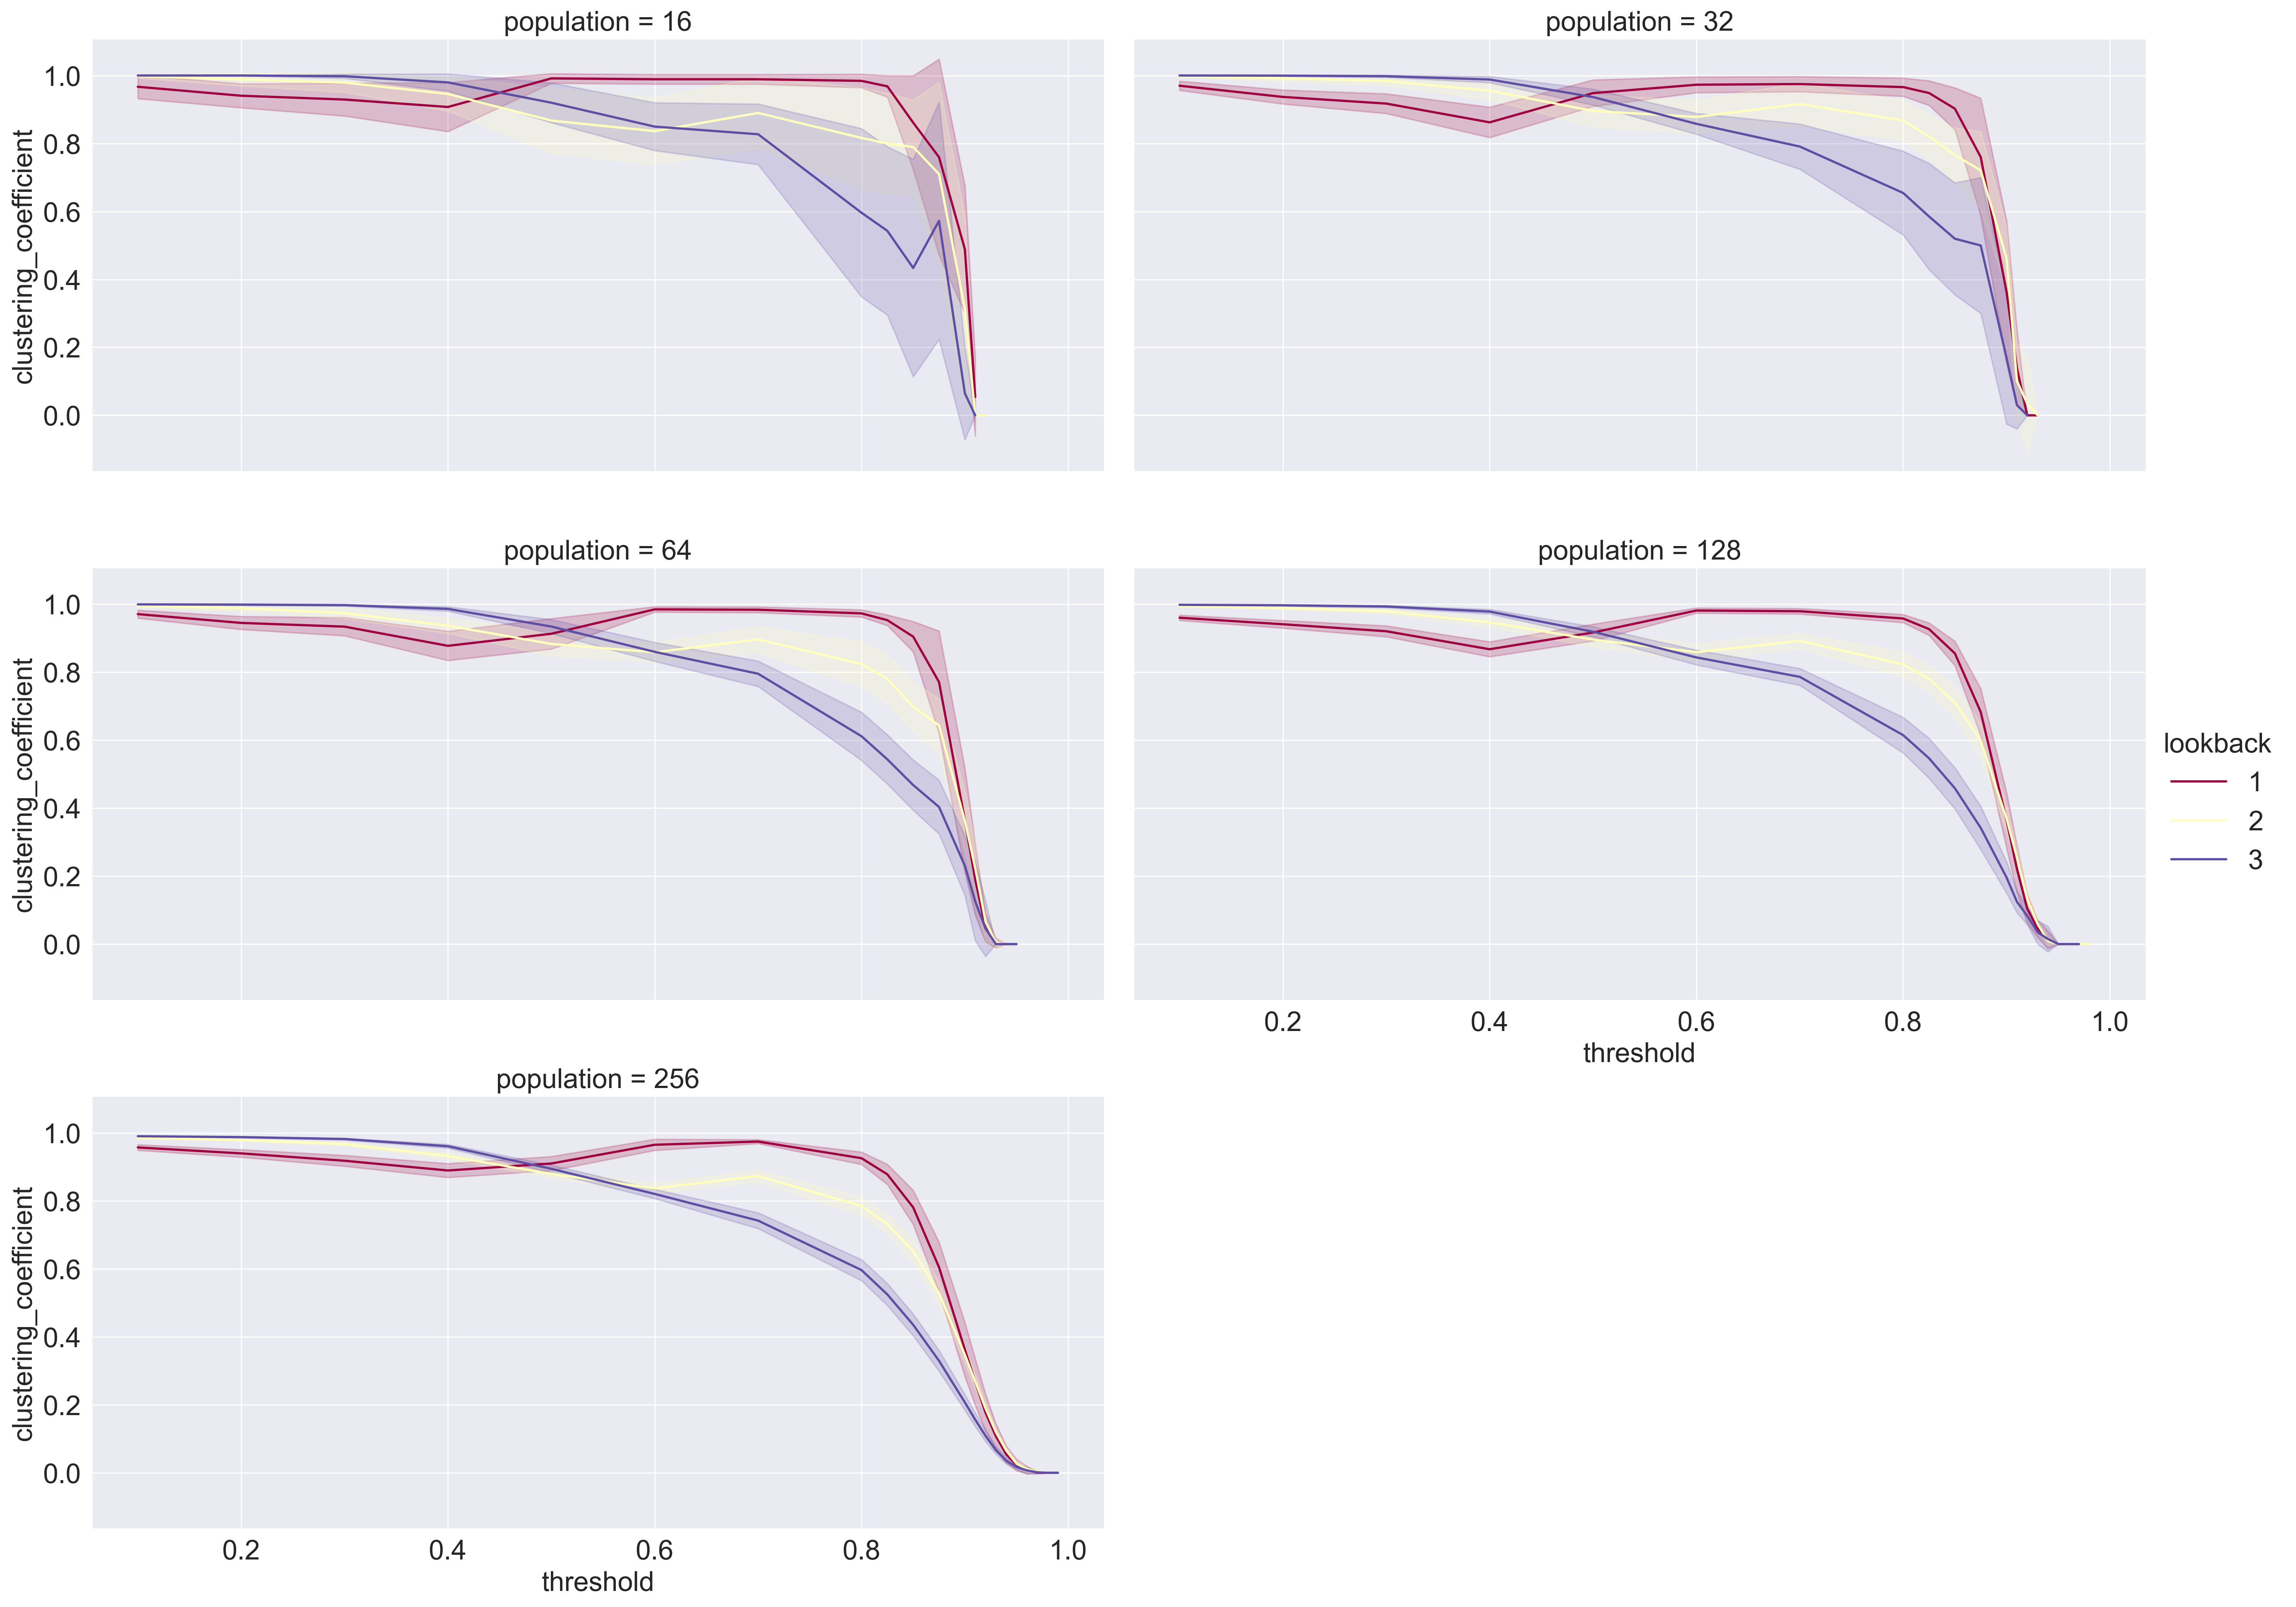

In [6]:
sns.set_style("darkgrid")
sns.relplot(
    data=df,
    x="threshold",
    y="clustering_coefficient",
    hue="lookback",
    col="population",
    col_wrap=2,
    kind="line",
    aspect=2,
    palette="Spectral",
    errorbar="sd",
)

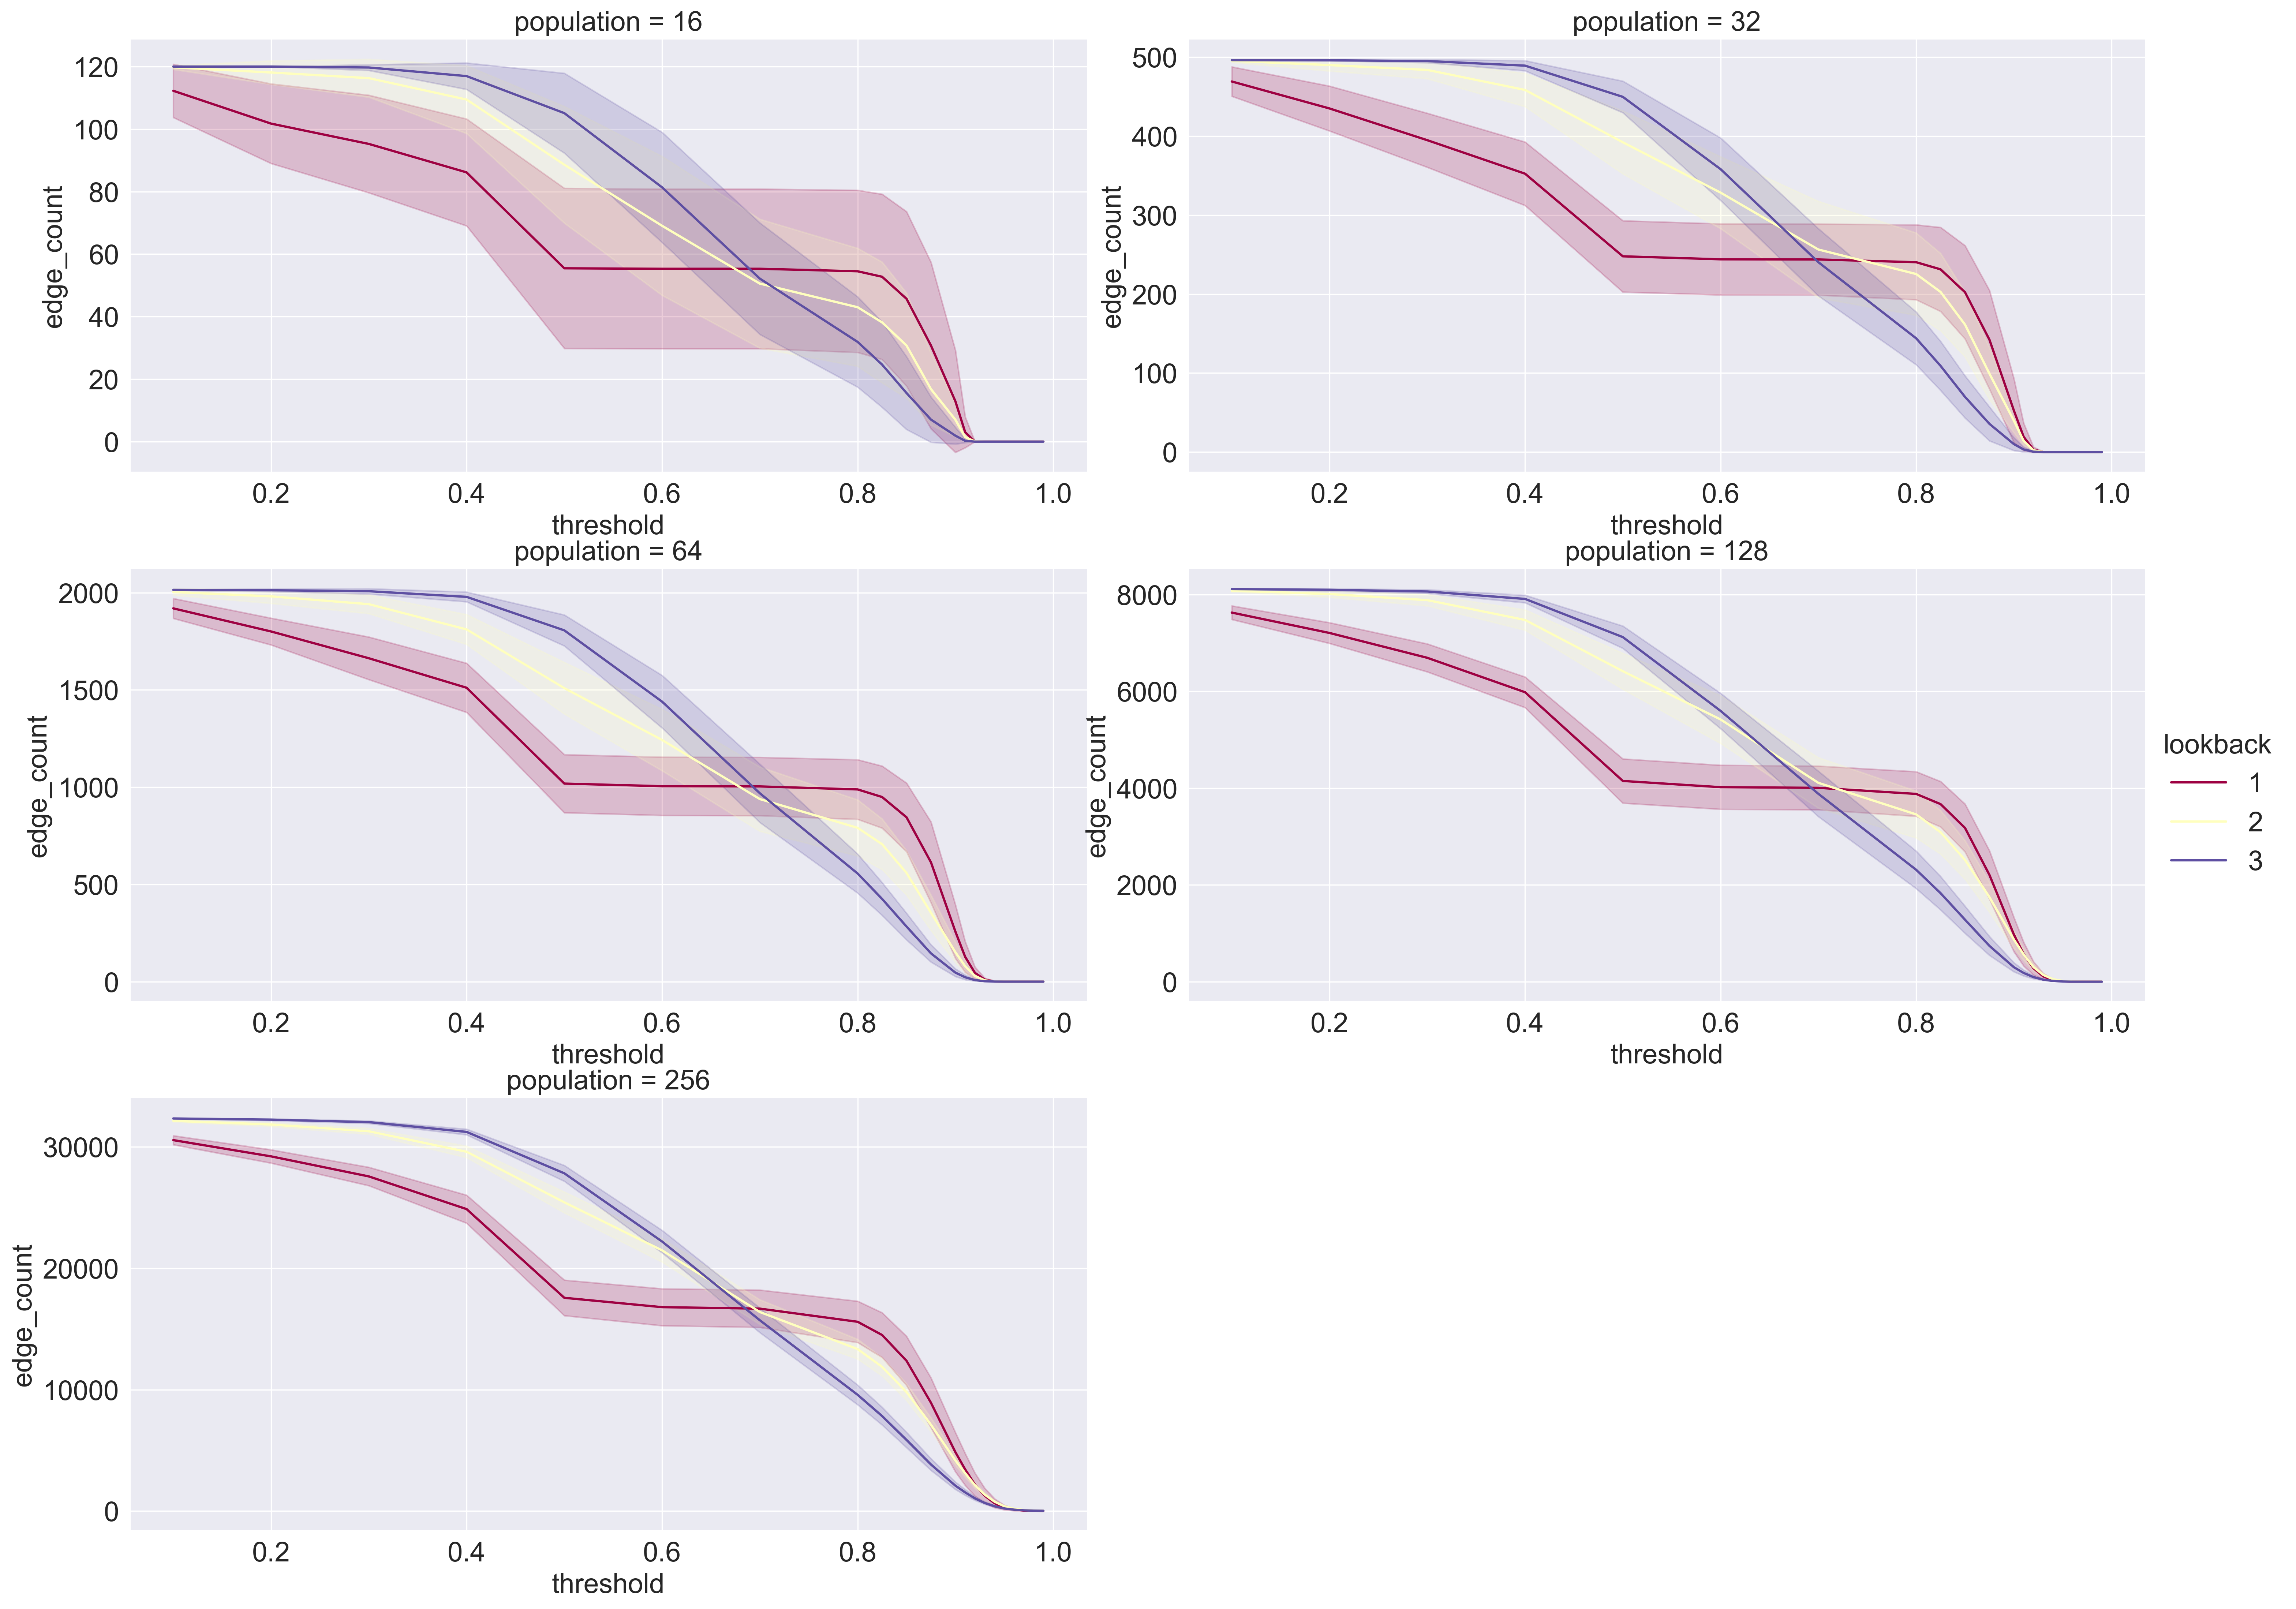

In [7]:
sns.set_style("darkgrid")
sns.relplot(
    data=df,
    x="threshold",
    y="edge_count",
    hue="lookback",
    col="population",
    col_wrap=2,
    kind="line",
    aspect=2,
    palette="Spectral",
    facet_kws={"sharey": False, "sharex": False},
    errorbar="sd",
)

In [8]:
agg_df = (
    df[df["threshold"] == 0.9]
    .groupby(["population", "lookback", "threshold"])
    .agg(
        {
            "clustering_coefficient": ["mean", "std"],
        }
    )
    .round(3)
)

agg_df

clustering_coefficient       
                                                mean    std
population lookback threshold                              
16         1        0.9                        0.489  0.188
           2        0.9                        0.313  0.272
           3        0.9                        0.065  0.137
32         1        0.9                        0.363  0.210
           2        0.9                        0.462  0.095
           3        0.9                        0.168  0.194
64         1        0.9                        0.364  0.153
           2        0.9                        0.363  0.089
           3        0.9                        0.230  0.087
128        1        0.9                        0.364  0.082
           2        0.9                        0.369  0.037
           3        0.9                        0.196  0.046
256        1        0.9                        0.363  0.080
           2        0.9                        0.347  0.026
           3        0.9                        0.207  0.023

In [9]:
for population, row in (
    agg_df.reset_index().pivot("population", columns="lookback").iterrows()
):
    print(
        population,
        *(
            f"${mean:.3f} \pm {std:.3f}$"
            for mean, std in zip(
                row["clustering_coefficient"]["mean"],
                row["clustering_coefficient"]["std"],
            )
        ),
        sep="\t&\t",
        end=" \\\\\n",
    )

16	&	$0.489 \pm 0.188$	&	$0.313 \pm 0.272$	&	$0.065 \pm 0.137$ \\
32	&	$0.363 \pm 0.210$	&	$0.462 \pm 0.095$	&	$0.168 \pm 0.194$ \\
64	&	$0.364 \pm 0.153$	&	$0.363 \pm 0.089$	&	$0.230 \pm 0.087$ \\
128	&	$0.364 \pm 0.082$	&	$0.369 \pm 0.037$	&	$0.196 \pm 0.046$ \\
256	&	$0.363 \pm 0.080$	&	$0.347 \pm 0.026$	&	$0.207 \pm 0.023$ \\


C:\Users\jerem\AppData\Local\Temp/ipykernel_24324/3056726541.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  for population, row in agg_df.reset_index().pivot("population", columns="lookback").iterrows():
